% a few user-defined LaTeX commands
$
\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\bkappa}{\boldsymbol{\kappa}}
\newcommand{\DD}{\mathbb{D}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\bI}{\boldsymbol{I}}
\newcommand{\bV}{\boldsymbol{V}}
\newcommand{\bU}{\boldsymbol{U}}
\newcommand{\bt}{\boldsymbol{n}}
\newcommand{\bn}{\boldsymbol{t}}
\newcommand{\T}{{}^\text{T}} 
\newcommand{\div}{\operatorname{div}}
\newcommand{\jump}[1]{[\![#1]\!]}
\newcommand{\avg}[1]{\left\langle#1\right\rangle}$

# Multiphase model for fiber-reinforced materials


This demo explores the full capability of MFront's recent extension to handling generalized behaviours, namely involving different pairs of fluxes and gradients, as well as FEniCS versatility to solve generic PDEs.

This will be illustrated on a generalized continuum model called *multiphase model* in the context of fiber-reinforced materials <cite data-cite="bleyer2018multiphase">(Bleyer, 2018)</cite>.

## A quick primer on the multiphase model

The multiphase model is a higher-grade (i.e. with enhanced kinematics) generalized continuum which represents a biphasic material (the main application being fiber-reinforced materials) by a superposition of two phases (say *matrix* and *fiber* phases), each possessing their own kinematics and in mutual interaction. Each phase kinematics is described by a displacement field $\bU^1$ and $\bU^2$ for the matrix and fiber phase respectively.

In the present case, each phase is a standard Cauchy continuum but other variants, including fiber bending effects for instance, exist, see <cite data-cite="debuhan2017elastic">(de Buhan et al., 2017)</cite> for more details.

* **Generalized strains**: infinitesimal strain in each phase $\beps^j=\nabla^s \bU^j$ and relative displacement between both phases $\bV = \bU^2-\bU^1$

* **Generalized stresses**: partial stress $\bsig^j$ in both phases and interaction force $\bI$ (exerted by phase 2 over phase 1)

* **Equilibrium equations**:
\begin{align}
\div \bsig^1 +\rho_1F + \bI &=  0 \label{multiphase-eq1}\\
\div \bsig^2 + \rho_2F - \bI &= 0 \label{multiphase-eq2}
\end{align}

* **Traction boundary conditions**:
\begin{align}
\bsig^1\cdot\bn &= \bt^1 \text{ on }\partial \Omega_{T} \\
\bsig^2\cdot\bn &= \bt^2 \text{ on } \partial \Omega_{T} 
\end{align}

* **Deformation work density**:
\begin{equation}
w_{\text{def}} = \bsig^1:\beps^1 + \bsig^2:\beps^2+ \bI\cdot\bV
\end{equation}

* General form of the **constitutive equations** based on a convex free energy density $\psi$:
\begin{align}
\bsig^1 &= \dfrac{\partial \psi}{\partial \beps^1}(\beps^1,\beps^2,\bV) \\
\bsig^2 &= \dfrac{\partial \psi}{\partial \beps^2}(\beps^1,\beps^2,\bV)\\
\bI &= \dfrac{\partial \psi}{\partial \bV}(\beps^1,\beps^2,\bV)
\end{align}

which will be particularized for the present demo to the following *elastic behaviour*:

\begin{align*}
\bsig^1 &= \DD^{11}:\beps^1+\DD^{12}:\beps^2\\
\bsig^2 &= (\DD^{12})\T:\beps^1+\DD^{22}:\beps^2\\
\bI &= \bkappa \cdot \bV
\end{align*}
in which $\DD^{ij}$ are partial stiffness tensors and $\kappa$ can be seen as an interaction stiffness between both phases.

## MFront implementation

The MFront implementation expands upon the detailed MFront implementation of the [stationnary heat transfer demo](nonlinear_heat_transfer.ipynb). Again, the  `DefaultGenericBehaviour` is used here and specify that the following implementation will only handle the 2D plane strain case.
``` cpp
@DSL DefaultGenericBehaviour;
@Behaviour MultiphaseModel;
@Author Jeremy Bleyer;
@Date 04/04/2020;

@ModellingHypotheses {PlaneStrain};
```

The three pairs of generalized flux/gradient of the multiphase model are then defined, namely $(\bsig^1,\beps^1)$, $(\bsig^2,\beps^2)$ and $(\bI,\bV)$: 

``` cpp
@Gradient StrainStensor e₁;
e₁.setEntryName("MatrixStrain");
@Flux StressStensor σ₁;
σ₁.setEntryName("MatrixStress");

@Gradient StrainStensor e₂;
e₂.setEntryName("FiberStrain");
@Flux StressStensor σ₂;
σ₂.setEntryName("FiberStress");

@Gradient Stensor V;
V.setEntryName("RelativeDisplacement");
@Flux Stensor I;
I.setEntryName("InteractionForce");
```
Note that $\bI$ and $\bV$ should normally be declared as vectors whereas here they have been declared as symmetric tensors. This has been done due to the current (version <= 3.4) MFront limitation of handling derivatives of tensors with respect to vectors (and vice versa). We therefore made the choice of representing both $\bI$ and $\bV$ as tensorial variables, the diagonal of which corresponding to the original vector, so that all gradient and fluxes are tensors.

We now declare the various tangent operator blocks which will be needed to express the generalized tangent operator. Of the nine possible blocks, only 5 are needed here since the partial stresses do not depend on the relative displacement and, similarly, the interaction force does not depend on the phase strains:

```cpp
@TangentOperatorBlock ∂σ₁∕∂Δe₁;
@AdditionalTangentOperatorBlock ∂σ₁∕∂Δe₂;
@AdditionalTangentOperatorBlock ∂σ₂∕∂Δe₁;
@AdditionalTangentOperatorBlock ∂σ₂∕∂Δe₂;
@AdditionalTangentOperatorBlock ∂I∕∂ΔV;
```

### Defining material properties
We consider the case of a 2D plane strain bilayered material made of isotropic materials for both the matrix and fiber phases. In addition to the four material constants need for both constituents, the volume fraction of both phases (here we ask for the volume fraction $\rho$ of the fiber phase) and the size $s$ of the material unit cell (i.e. the spacing between two consecutive matrix layers for instance) are the two other parameters characterizing the multiphase elastic model.

```cpp
@MaterialProperty stress Y1;
Y1.setEntryName("MatrixYoungModulus");
@MaterialProperty real nu1;
nu1.setEntryName("MatrixPoissonRatio");
@MaterialProperty stress Y2;
Y2.setEntryName("FiberYoungModulus");
@MaterialProperty real nu2;
nu2.setEntryName("FiberPoissonRatio");
@MaterialProperty real ρ;
ρ.setEntryName("FiberVolumeFraction");
@MaterialProperty real s;
s.setEntryName("Size");
```

It has been shown in <cite data-cite="bleyer2018multiphase">(Bleyer, 2018)</cite> that, for materials made of two constituents, the partial stiffness tensors $\DD^{ij}$ can be expressed as functions of the material individual stiffness $\CC^1,\CC^2$ and the macroscopic stiffness $\CC^{hom}$ of the composite (obtained from classical homogenization theory) as follows:

\begin{align*}
\DD^{11} &= \phi_1\CC^1-\CC^1:\jump{\CC}^{-1}:\Delta\CC:\jump{\CC}^{-1}:\CC^1\\ 
\DD^{22} &= \phi_2\CC^2-\CC^2:\jump{\CC}^{-1}:\Delta\CC:\jump{\CC}^{-1}:\CC^2\\ 
\DD^{12} &= \CC^1:\jump{\CC}^{-1}:\Delta\CC:\jump{\CC}^{-1}:\CC^2
\end{align*}


with $\phi_1=1-\rho$, $\phi_2 = \rho$ are the phases volume fractions, $\jump{\CC}=\CC^2-\CC^1$ and $\Delta\CC = \phi_1\CC^1+\phi_2\CC^2-\CC^{hom}$. They satisfy the following property $\DD^{11}+\DD^{22}+\DD^{12}+(\DD^{21})\T=\CC^{hom}$.

In the present case of a 2D bilayered material made of isotropic constituents, the macroscopic stiffness is given by <cite data-cite="debuhan2017elastic">(de Buhan et al., 2017)</cite>:

\begin{equation}
\CC^{hom} = \begin{bmatrix}
\avg{E_\text{oe}} - \avg{\lambda^2/E_\text{oe}}+\avg{\lambda/E_\text{oe}}^2/\avg{1/E_\text{oe}} & \avg{\lambda/E_\text{oe}}/\avg{1/E_\text{oe}} & \avg{\lambda/E_\text{oe}}/\avg{1/E_\text{oe}} & 0 \\
\avg{\lambda/E_\text{oe}}/\avg{1/E_\text{oe}} & 1/\avg{1/E_\text{oe}} & \avg{\lambda} & 0 \\
\avg{\lambda/E_\text{oe}}/\avg{1/E_\text{oe}} & \avg{\lambda} & \avg{E_\text{oe}} & 0 \\
0 & 0 & 0 & 2/\avg{1/\mu}
\end{bmatrix}_{(xx,yy,zz,xy)}
\end{equation}

where $\avg{\star}=\phi_1\star_1+\phi_2\star_2$ denotes the averaging operator and $E_\text{oe}=\lambda+2\mu$ is the oedometric modulus.

As regards the interaction stiffness tensor, it is obtained from the resolution of an auxiliary homogenization problem formulated on the heterogeneous material unit cell. In the present case, one obtains <cite data-cite="bleyer2018multiphase">(Bleyer, 2018)</cite>:

\begin{equation}
\bkappa = \begin{bmatrix}
\dfrac{12}{\avg{\mu}s^2} & 0 \\
0 & \dfrac{12}{\avg{E_\text{oe}}s^2}
\end{bmatrix}_{(x,y)}
\end{equation}

These relations are all implemented in the behaviour `@Integrator` which also defines the required tangent blocks.  MFront linear algebra on fourth-order tensor makes the implementation very easy and Unicode support provides much more readable code.

```cpp
@ProvidesTangentOperator;
@Integrator {
  // remove useless warnings, as we always compute the tangent operator
  static_cast<void>(computeTangentOperator_);

  const auto λ₁ = computeLambda(Y1,nu1);
  const auto μ₁ = computeMu(Y1,nu1);
  const auto λ₂ = computeLambda(Y2,nu2);
  const auto μ₂ = computeMu(Y2,nu2);
  const auto Eₒₑ¹ = λ₁+2*μ₁;
  const auto Eₒₑ² = λ₂+2*μ₂;
  const auto Eₒₑ = (1-ρ)*Eₒₑ¹ + ρ*Eₒₑ²;
  const auto iEₒₑ = (1-ρ)/Eₒₑ¹ + ρ/Eₒₑ²;
  const auto λ = (1-ρ)*λ₁ + ρ*λ₂;
  const auto λiEₒₑ = (1-ρ)*λ₁/Eₒₑ¹ + ρ*λ₂/Eₒₑ²;
  const auto λ2iEₒₑ = (1-ρ)*pow(λ₁,2)/Eₒₑ¹ + ρ*pow(λ₂,2)/Eₒₑ²;
  const auto iμ = (1-ρ)/μ₁ + ρ/μ₂;
  const auto C₁₁₁₁ʰᵒᵐ = Eₒₑ - λ2iEₒₑ + pow(λiEₒₑ,2)/iEₒₑ;
  const auto C₁₁₂₂ʰᵒᵐ = λiEₒₑ/iEₒₑ;
  const Stensor4 Cʰᵒᵐ = {
      C₁₁₁₁ʰᵒᵐ , C₁₁₂₂ʰᵒᵐ, C₁₁₂₂ʰᵒᵐ, 0., //
      C₁₁₂₂ʰᵒᵐ, 1/iEₒₑ, λ, 0., //
      C₁₁₂₂ʰᵒᵐ, λ, Eₒₑ, 0., //
      0., 0., 0., 2/iμ
  };
  const auto C¹ = λ₁ ⋅ (I₂ ⊗ I₂) + 2 ⋅ μ₁ ⋅ I₄;
  const auto C² = λ₂ ⋅ (I₂⊗I₂) + 2 ⋅ μ₂ ⋅ I₄;
  const auto iΔC = invert(C²-C¹);
  const auto Cᵃᵛᵍ = (1-ρ)⋅C¹ + ρ⋅C²;
  const auto H = iΔC ⋅ (Cᵃᵛᵍ-Cʰᵒᵐ) ⋅ iΔC;
  const auto D¹¹ = (1-ρ)⋅C¹-(C¹ ⋅ H ⋅ C¹);
  const auto D²² = ρ⋅C²-(C² ⋅ H ⋅ C²);
  const auto D¹² = C¹ ⋅ H ⋅ C²;
  ∂σ₁∕∂Δe₁ = D¹¹;
  ∂σ₁∕∂Δe₂ = D¹²;
  ∂σ₂∕∂Δe₁ = transpose(D¹²);
  ∂σ₂∕∂Δe₂ = D²²;
  σ₁ = ∂σ₁∕∂Δe₁ ⋅ (e₁ + Δe₁) + ∂σ₁∕∂Δe₂ ⋅ (e₂ + Δe₂);
  σ₂ = ∂σ₂∕∂Δe₁ ⋅ (e₁ + Δe₁) + ∂σ₂∕∂Δe₂ ⋅ (e₂ + Δe₂);

  const auto κʰ = 12/iμ/pow(s,2); // horizontal interaction stiffness
  const auto κᵛ = 12/iEₒₑ/pow(s,2); // vertical interaction stiffness
  const Stensor4 κ = {
      κʰ, 0., 0., 0., //
      0., κᵛ, 0., 0., //
      0., 0., 0., 0., //
      0., 0., 0., 0.
  };
  ∂I∕∂ΔV = κ;
  I = κ ⋅ (V + ΔV);
}
```
Let us finally remark that since $\bI$ and $\bV$ have been represented by second-order tensors, the stiffness interaction tensor $\bkappa$ is itself represented as a fourth-order tensor, with only its first two diagonal components which are useful.

## FEniCS implementation

We consider a rectangular domain with a standard $P_1$ Lagrange interpolation for both displacement fields $\bU^1,\bU^2$. The total mixed function space `V` is therefore made of two vectorial $P_1$ Lagrange elementary spaces. The same boundary conditions will be applied for both phases: fixed vertical displacement on the bottom boundary, imposed vertical displacement on the top boundary and fixed horizontal displacement on the left boundary. The considered problem corresponds to the pure compression of a multilayered block, an example treated in the previously mentioned references.

In such a problem, both phase strains are uniform along the vertical direction solution but vary along the horizontal direction due to a boundary layer effect appearing near the right free-edge. Such a feature cannot be captured by a classical Cauchy continuum but is well reproduced by the multiphase model.


In [1]:
import matplotlib.pyplot as plt
from dolfin import *
import mfront_wrapper as mf
import numpy as np
from ufl import diag

width = 0.5
height = 1.
mesh = RectangleMesh(Point(0., 0.), Point(width, height), 100, 100)

Ve = VectorElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, MixedElement([Ve, Ve]))
u = Function(V, name="Displacements")
(u1, u2) = split(u)

def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
def top(x, on_boundary):
    return near(x[1], height) and on_boundary
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary


bc = [DirichletBC(V.sub(0).sub(0), Constant(0), left),
      DirichletBC(V.sub(1).sub(0), Constant(0), left),
      DirichletBC(V.sub(0).sub(1), Constant(0), bottom),
      DirichletBC(V.sub(1).sub(1), Constant(0), bottom),
      DirichletBC(V.sub(0).sub(1), Constant(-1), top),
      DirichletBC(V.sub(1).sub(1), Constant(-1), top)]

facets = MeshFunction("size_t", mesh, 1)
ds = Measure("ds", subdomain_data=facets)



After having defined the `MFrontNonlinearMaterial` and `MFrontNonlinearProblem` instances, one must register the UFL expression of the gradients defined in the MFront file since, in this case, automatic registration is not available for this specific model. The matrix (resp. fiber) strains $\beps^1$ (resp. $\beps^2$) is simply given by `sym(grad(u1))` (resp. `sym(grad(u2))`) whereas the relative displacement $\bV$ should be `u2-u1`. Again, since $\bV$ has been represented as a tensor on the MFront side, we register it as `ufl.diag(u2-u1)` i.e. a tensor whose diagonal is `u2-u1`:

In [2]:
mat_prop = {"MatrixYoungModulus": 10.,
            "MatrixPoissonRatio": 0.45,
            "FiberYoungModulus": 10000,
            "FiberPoissonRatio": 0.3,
            "FiberVolumeFraction": 0.01,
            "Size": 1/16.}

material = mf.MFrontNonlinearMaterial("../materials/src/libBehaviour.so",
                                      "MultiphaseModel",
                                      hypothesis="plane_strain",
                                      material_properties=mat_prop, is_finite_strain=None)

problem = mf.MFrontNonlinearProblem(u, material, quadrature_degree=0, bcs=bc)
problem.register_gradient("MatrixStrain", sym(grad(u1)))
problem.register_gradient("FiberStrain", sym(grad(u2)))
problem.register_gradient("RelativeDisplacement", diag(u2-u1))

problem.solve(u.vector())

Automatic registration of 'Temperature' as a Constant value = 293.15.



(1, True)

We compare the horizontal displacements in both phases with respect to known analytical solutions for this problem in the case of very stiff inclusions $E_2 \gg E_1$ in small volume fraction $\eta \ll 1$ (see <cite data-cite="debuhan2017elastic">de Buhan et al., 2017</cite>). Note that the more complete solution for the general case can be found in  <cite data-cite="bleyer2018multiphase">(Bleyer, 2018)</cite>.

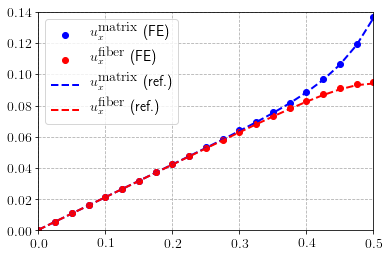

In [3]:
x = np.linspace(0, width, 21)
plt.figure()
plt.plot(x, np.array([u(xi, height/2)[0] for xi in x]), "ob", label=r"$u_x^\textrm{matrix}$ (FE)")
plt.plot(x, np.array([u(xi, height/2)[2] for xi in x]), "or", label=r"$u_x^\textrm{fiber}$ (FE)")

E1 = mat_prop["MatrixYoungModulus"]
nu1 = mat_prop["MatrixPoissonRatio"]
E2 = mat_prop["FiberYoungModulus"]
nu2 = mat_prop["FiberPoissonRatio"]
eta = mat_prop["FiberVolumeFraction"]
s = mat_prop["Size"]
mu1 = E1/2/(1+nu1)
mu2 = E2/2/(1+nu2)
lmbda1 = E1*nu1/(1+nu1)/(1-2*nu1)
lmbda2 = E2*nu2/(1+nu2)/(1-2*nu2)
kappa = 12*mu1*mu2/((1-eta)*mu2+eta*mu1)/s**2 # horizontal interaction stiffness
Eo1 = lmbda1+2*mu1 # oedometric modulus for phase 1
Eo2 = lmbda2+2*mu2 # oedometric modulus for phase 1
Er = eta*E2/(1-nu2**2) 
ahom = Eo1+Er
l = sqrt(Eo1*Er/ahom/kappa) # material characteristic length scale
um = lmbda1/ahom*(x+l*(Er/Eo1)*np.sinh(x/l)/np.cosh(width/l))
ur = lmbda1/ahom*(x-l*np.sinh(x/l)/np.cosh(width/l))
plt.plot(x, um, '--b', label=r"$u_x^\textrm{matrix}$ (ref.)")
plt.plot(x, ur, '--r', label=r"$u_x^\textrm{fiber}$ (ref.)")
plt.legend()
plt.show()